# Bayesian PCA
Includes bias and noise.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Normal, StudentT

In [2]:
import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')

import bijectors as bijector

In [3]:
# note that in the function below D should be greater then K
def build_toy_dataset(N, D, K):
    x_train = np.zeros([D, N])
    w = np.zeros([D,K])
    for k in range(K):
        w[k,k]=1.0/(k+1)
        w[k+1,k]=-1.0/(k+1)
    print(w)
    z = np.random.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    shift=np.zeros([D])
    shift[0]=10
    shift[1]=23
    sigma = np.ones(D)+0.1
    for d in range(D):
      for n in range(N):
        x_train[d, n] = np.random.normal(mean[d, n], sigma[d])+shift[d]
#     print("True principal axes:")
#     print(w)
#     print("Shift:")
#     print(shift)
    return x_train.astype(np.float32,copy=False), w, shift, sigma


#ed.set_seed(142)

N = 1000  # number of data points
D = 6  # data dimensionality
K = 3 # latent dimensionality

# DATA

x_train, w_true, shift, sigma_true = build_toy_dataset(N, D, K)

[[ 1.          0.          0.        ]
 [-1.          0.5         0.        ]
 [ 0.         -0.5         0.33333333]
 [ 0.          0.         -0.33333333]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


In [4]:
shift

array([ 10.,  23.,   0.,   0.,   0.,   0.])

In [5]:
sigma_true

array([ 1.1,  1.1,  1.1,  1.1,  1.1,  1.1])

## Adding a diagonal noise covariance matrix

So far we used the knowledge on the dimensionality of the latent space by setting $K=1$.  We can determine the number of latent dimensions by setting a higher $K$ (in this case $K=2$) and adding another prior $\alpha=(\alpha_1,\dots,\alpha_K)$ for the scale of each dimension.
\begin{align}
\alpha_j&\sim Gamma(1,1)\\
w_{ij}&\sim N(0,\alpha_j)\\
z_j&\sim N(0,1)\\
\mu_i &\sim N(0,1)\\
\sigma_i &\sim Gamma(1,1)\\
x_i&\sim N((w\cdot z)_i+\mu_i,\sigma_i)\\
\end{align}

We expect the posterior for either $\alpha_1$ or $\alpha_2$, say $\alpha_2$, to drop down to zero, signaling that there are is only one significant dimension left, $\alpha_1\ne0$.

### The automatic relevance determination in higher dimensions

The ARD might seem like an overkill but it comes in handy in higher dimensions, where the dimensionality of the latent space is not a prior known.  Let us generate a higher dimensional data set and see how ARD determines the latent dimensionality.

In [6]:
class low_rank_mvn_horseshoe_ard():
    def __init__(self,M,D):
        # Fit as many latent variables as dimensions, prune by ARD
        K=D
        #########
        # halfCauchy = StudentT(df=1., loc=0., scale=1.)
        # Horseshoe! Happy now, Aki? Hyva!
        #########
        # P-model
        sigma = ed.models.Gamma(tf.ones([D]),tf.ones([D]))
        #alpha = ed.models.Gamma(tf.ones([K]),tf.ones([K]))
        lamda = StudentT(df=1., loc=tf.zeros([K]), scale=tf.ones([K]))
        tau = StudentT(df=1., loc=0., scale=1.)
        w = Normal(tf.zeros([D, K]),    tf.reshape(tf.tile(np.abs(tau)*np.abs(lamda),[D]),[D,K]))
        z = Normal(tf.zeros([K, M]),    tf.ones([K, M]))
        mu = Normal(tf.zeros([D]),       tf.ones([D]))
        x = ed.models.MultivariateNormalDiag(tf.add(tf.transpose(tf.matmul(w, z)),mu), tf.reshape(tf.tile(sigma,[M]),[M,D]))

        self.Pmodel = (sigma,lamda,tau,w,z,mu)
        self.x = x
        #########
        # Q-model
        qtau = ed.models.TransformedDistribution(
        distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.random_normal([])),
                                                       tf.Variable(tf.random_normal([]))),
        bijector=bijector.Exp(),
        name="qtau")
        qlamda = ed.models.TransformedDistribution(
        distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros([K])),
                                                       tf.Variable(tf.zeros([K]))),
        bijector=bijector.Exp(),
        name="qlamda")
        #qalpha = ed.models.TransformedDistribution(
        #    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.random_normal([K])),
        #                                                   tf.Variable(tf.random_normal([K]))),
        #    bijector=bijector.Exp(),
        #    name="qalpha")
        qw = Normal(tf.Variable(tf.random_normal([D, K])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
        qz = Normal(tf.Variable(tf.random_normal([K, M])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([K, M]))))

        # assume standardized data
        qmu = Normal(tf.Variable(tf.random_normal([D])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
        qsigma = ed.models.TransformedDistribution(
            distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros(D)),
                                          tf.Variable(tf.ones(D))),
            bijector=bijector.Exp(),
            name="qsigma")

        self.Qmodel = (qsigma,qlamda,qtau,qw,qz,qmu)
        
    def initialize(self, x_train):
        '''
        Initialize parameters of Q-model in the solution from PCA, and empirical means and standard deviations, for faster convergence.
        '''
        K=D
        qsigma,qlamda,qtau,qw,qz,qmu = self.Qmodel
        # set qmu mean to data mean
        data_mean = np.mean(x_train,axis=1).astype(np.float32,copy=False)
        qmu = Normal(tf.Variable(data_mean+tf.random_normal([D])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
        # set qw mean to pca solution
        U,_,_ = np.linalg.svd(x_train)
        qw = Normal(tf.Variable(U+tf.random_normal([D, K])),
                    tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
        # set qsigma mean to data stds
        data_std = np.std(x_train,axis=1).astype(np.float32,copy=False)
        qsigma = ed.models.TransformedDistribution(
            distribution=ed.models.NormalWithSoftplusScale(tf.Variable(np.log(data_std)),
                                          tf.Variable(tf.ones(D)*3)),
            bijector=bijector.Exp(),
            name="qsigma")
        self.Qmodel = (qsigma,qlamda,qtau,qw,qz,qmu)

    def infer(self, x_train, n_epoch = 100, n_print=100, n_samples=100, M = 100, optimizer='rmsprop'):
        # add mini-batches
        def generator(arrays, batch_size):
            """Generate batches, one with respect to each array's first axis."""
            starts = [0] * len(arrays)  # pointers to where we are in iteration
            while True:
                batches = []
                for i, array in enumerate(arrays):
                    start = starts[i]
                    stop = start + batch_size
                    diff = stop - array.shape[0]
                    if diff <= 0:
                        batch = array[start:stop]
                        starts[i] += batch_size
                    else:
                        batch = np.concatenate((array[start:], array[:diff]))
                        starts[i] = diff
                    batches.append(batch)
                yield batches
        x_ph = tf.placeholder(tf.float32, [None, D])
        data = generator([x_train.T], M)
        n_batch = int(N / M)
        # add progress bar
        x = self.x
        inference = ed.KLqp(dict(zip(self.Pmodel,self.Qmodel)), data={x: x_ph})
        inference.initialize(n_iter=n_batch * n_epoch, n_print=(n_batch * n_epoch)/10, n_samples=n_samples)

        sess = ed.get_session()
        init = tf.global_variables_initializer()
        init.run()

        # assert x_ph.shape[0] == M 
        learning_curve = []
        for _ in range(inference.n_iter):
            x_batch = next(data)[0]
            info_dict = inference.update({x_ph: x_batch})
            if _%inference.n_print == 0:
                print(info_dict)
            learning_curve.append(info_dict['loss'])
        plt.semilogy(learning_curve)
        plt.show()
    
    def prior_predictive_check(self):
        self.x_prior = ed.copy(self.x)
        pass
        
    def posterior_predictive_check(self, x_test):
        self.x_post = ed.copy(self.x, dict(zip(self.Pmodel,self.Qmodel)))
        return ed.evaluate('log_likelihood', data={self.x_post: x_test})
    
    def print_model(self):
        qsigma,qlamda,qtau,qw,qz,qmu = self.Qmodel
        # add pair plots
        print("Inferred principal axes (columns):")
        print(qw.mean().eval())
        print(qw.variance().eval())
        print("Inferred center:")
        print(qmu.mean().eval())
        print(qmu.variance().eval())

In [7]:
M = 1000
meddle = low_rank_mvn_horseshoe_ard(M,D)
meddle.initialize(x_train)

meddle.prior_predictive_check()

# sample all variables ancestrally
model = meddle.x_prior.get_ancestors()
model.append(meddle.x_prior)
model_sample = dict(zip(model,sess.run([v.value() for v in model])))

sess = ed.get_session()
tmp = meddle.x_prior.sample().eval().T
with sess.as_default():
    plt.scatter(*tmp)
    plt.scatter(*x_train[:,:M])
    plt.axis('equal')
    plt.show()

In [ ]:
meddle.infer(x_train, M=M, n_epoch = 200, n_samples = 150)

In [ ]:
meddle.posterior_predictive_check(x_train[:,:M].T)

In [ ]:
x_post_mode = meddle.x_post.mode().eval()

In [ ]:
def plot_against_training_set(x):
    x_train_sample = x_train[:,:M]
    for i in range(D-2):
        plt.scatter(*x_train_sample[i:i+2,:])
        plt.scatter(*x.T[i:i+2,:],alpha=.1)
        plt.axis('equal')
        plt.show()
    plt.scatter(*x_train_sample[(D-2):D,:])
    plt.scatter(*x.T[(D-2):D,:],alpha=.1)
    plt.axis('equal')
    plt.show()

In [ ]:
plot_against_training_set(x_post_mode)

In [14]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

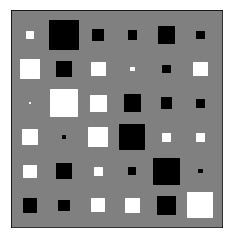

In [24]:
w_hat = meddle.Qmodel[3].mean().eval()
hinton(w_hat)
plt.show()

In [16]:
np.round(w_hat,2)

array([[ 0.20999999,  1.16999996,  0.01      ,  0.79000002,  0.50999999,
        -0.61000001],
       [-2.98000002, -0.77999997,  2.5       , -0.03      , -0.76999998,
        -0.40000001],
       [-0.41      ,  0.63999999,  0.86000001,  1.23000002,  0.20999999,
         0.58999997],
       [-0.23999999,  0.05      , -0.94999999, -2.1099999 , -0.15000001,
         0.72000003],
       [-0.94999999, -0.2       , -0.38      ,  0.2       , -2.33999991,
        -1.11000001],
       [-0.19      ,  0.63      , -0.23      ,  0.2       , -0.03      ,
         2.1500001 ]], dtype=float32)

In [17]:
w_true

array([[ 1.        ,  0.        ,  0.        ],
       [-1.        ,  0.5       ,  0.        ],
       [ 0.        , -0.5       ,  0.33333333],
       [ 0.        ,  0.        , -0.33333333],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

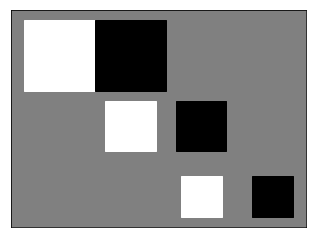

In [18]:
hinton(w_true)
plt.show()

In [19]:
qsigma.get_variables()[0].eval()

sorted(np.exp(qsigma.get_variables()[0].eval()))

tmp = qw.mean().eval()

tmp[abs(tmp)>0.05]

sigma

NameError: name 'qsigma' is not defined

In [ ]:
alphas=tf.exp(qalpha.distribution.mean()).eval()
alphas.sort()
plt.plot(range(alphas.size),alphas)
plt.show()

In [ ]:
plt.hist(qalpha.sample(1000).eval(),bins=20)
plt.xlim(0,2)
plt.show()

In [ ]:
qsigma.get_variables()[0].eval()

In [ ]:
x_train.shape

In [ ]:
x_sim_sample = x_sim.sample().eval()

In [ ]:
x_sim_sample

In [ ]:
x_sim_sample.shape

In [ ]:
D

In [ ]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
tpm = qtmp.sample(10000).eval()

plt.hist(tpm[:,0],'auto',normed=True)
plt.axis([0,50,0,1])
plt.show()
plt.hist(np.log(tpm[:,0]),'auto',normed=True)
plt.show()

In [ ]:
x_train.shape